# Chapter: Dimension Reduction and Latent Variable Methods (Part 1)


# Topic: Soft Sensing via PLS

In [1]:
# import required packages
import numpy as np
import pandas as pd

In [2]:
# fetch data
data = pd.read_csv('kamyr-digester.csv', usecols = range(1,23))    

In [5]:
# pre-process
# find the # of nan entries in each column
na_counts = data.isna().sum(axis = 0) 
na_counts

Y-Kappa              0
ChipRate             4
BF-CMratio          14
BlowFlow            13
ChipLevel4           1
T-upperExt-2         1
T-lowerExt-2         1
UCZAA               24
WhiteFlow-4          1
AAWhiteSt-4        141
AA-Wood-4            1
ChipMoisture-4       1
SteamFlow-4          1
Lower-HeatT-3        1
Upper-HeatT-3        1
ChipMass-4           1
WeakLiquorF          1
BlackFlow-2          1
WeakWashF            1
SteamHeatF-3         1
T-Top-Chips-4        1
SulphidityL-4      141
dtype: int64

In [ ]:
# pre-process continued
# remove columns that have a lot of nan entries
data_cleaned = data.drop(columns = ['AAWhiteSt-4 ','SulphidityL-4 ']) 

# remove any row that have any nan entry
data_cleaned = data_cleaned.dropna(axis = 0) 

# separate X, y
y = data_cleaned.iloc[:,0].values[:,np.newaxis] # StandardScaler requires 2D array
X = data_cleaned.iloc[:,1:].values

print('Number of samples left: ', X.shape[0])

In [4]:
# separate train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [6]:
# scale data
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train_normal = X_scaler.fit_transform(X_train)
X_test_normal = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_normal = y_scaler.fit_transform(y_train)
y_test_normal = y_scaler.transform(y_test)

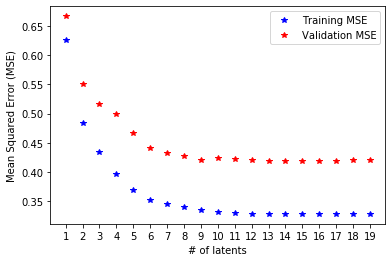

In [8]:
#%% Finding # latents using kFold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

scaler = StandardScaler()

fit_MSE = []
validate_MSE = []
for n_comp in range(1,20):
    local_fit_MSE = []
    local_validate_MSE = []
    
    kfold = KFold(n_splits = 10, shuffle = True, random_state = 100)
    for fit_index, validate_index in kfold.split(y_train):
        X_fit_normal = scaler.fit_transform(X_train[fit_index])
        X_validate_normal = scaler.transform(X_train[validate_index])
        
        y_fit_normal = scaler.fit_transform(y_train[fit_index])
        y_validate_normal = scaler.transform(y_train[validate_index])
        
        pls = PLSRegression(n_components = n_comp)
        pls.fit(X_fit_normal, y_fit_normal)
        
        local_fit_MSE.append(mean_squared_error(y_fit_normal, pls.predict(X_fit_normal)))
        local_validate_MSE.append(mean_squared_error(y_validate_normal, 
                                                        pls.predict(X_validate_normal)))
    
    fit_MSE.append(np.mean(local_fit_MSE))
    validate_MSE.append(np.mean(local_validate_MSE))


# plot
plt.figure()
plt.plot(range(1,20), fit_MSE, 'b*', label = 'Training MSE')
plt.plot(range(1,20), validate_MSE, 'r*', label = 'Validation MSE')
plt.xticks(range(1,20))
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('# of latents')
plt.legend()
plt.show()

In [9]:
# build PLS model
pls = PLSRegression(n_components = 9)
pls.fit(X_train_normal, y_train_normal)

PLSRegression(copy=True, max_iter=500, n_components=9, scale=True, tol=1e-06)

In [10]:
# check training vs test accuracy
y_train_normal_predict = pls.predict(X_train_normal)
y_test_normal_predict = pls.predict(X_test_normal)

print('Accuracy over training data: ', pls.score(X_train_normal, y_train_normal))
print('Accuracy over test data: ', pls.score(X_test_normal, y_test_normal))

Accuracy over training data:  0.6615034210369088
Accuracy over test data:  0.6815746388199421


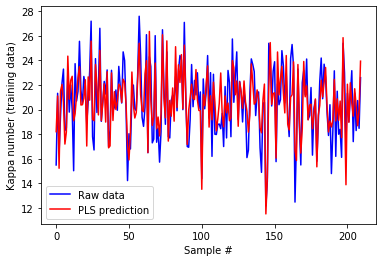

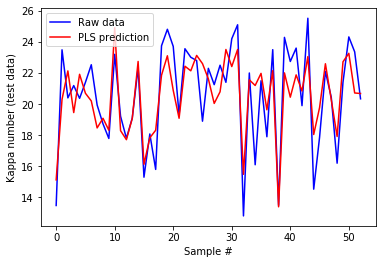

In [11]:
# plots of raw and predicted data
y_train_predict = y_scaler.inverse_transform(y_train_normal_predict)
y_test_predict = y_scaler.inverse_transform(y_test_normal_predict)

plt.figure()
plt.plot(y_train, 'b',  label = 'Raw data')
plt.plot(y_train_predict, 'r', label = 'PLS prediction')
plt.ylabel('Kappa number (training data)')
plt.xlabel('Sample #')
plt.legend()
plt.show()

plt.figure()
plt.plot(y_test, 'b',  label = 'Raw data')
plt.plot(y_test_predict, 'r',  label = 'PLS prediction')
plt.ylabel('Kappa number (test data)')
plt.xlabel('Sample #')
plt.legend()
plt.show()